# Modeling

I first perform some data processing where I transform, scale and one-hot encode several features. Then, I train, validate and test a logistic regression model and a XGBoost classifier. I also do some manual hyperparameter fine-tuning to address overfitting in the XGBoost classifier.

I proceed with a k-fold cross-validation using the models default implementation and compare their performance. Finally, I perform a hyperparameter tuning using cross-validation and compare the performance of the resulting models using a validation set.

I provide some basic comments within some code cells to follow what the code does.

## 1. Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, \
    GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
### The DataFrame is wide, so we'd like to be able to see all columns
pd.set_option('display.max_columns', None)

### Let's load the data into a DataFrame and check some basic info
creditCard = pd.read_csv("../UCI_Credit_Card.csv")
creditCard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [3]:
### We'll rename 'default.payment.next.month' to 'DEFAULT' for simplicity
creditCard.rename({"default.payment.next.month": "DEFAULT"}, axis = 1, inplace = True)

### We'll rename 'PAY_0' to 'PAY_1' to keep consistency in namings
creditCard.rename({"PAY_0": "PAY_1"}, axis = 1, inplace = True)
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## 2. Data processing

### 2.1.Feature transformation

According to the EDA, some continuous features exhibit non-normality. Below we apply the transformations that showed better results in the EDA. 

In [4]:
creditCard["LIMIT_BAL_sqrt"] = np.sqrt(creditCard["LIMIT_BAL"])
creditCard["BILL_AMT1_cbrt"] = np.cbrt(creditCard["BILL_AMT1"])

cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for col in cols:
    name = col + "_log"
    creditCard[name] = np.log(creditCard[col] + abs(creditCard[col].min()) + 0.001)

creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,BILL_AMT1_cbrt,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,15.758079,-6.907755,6.535243,-6.907755,-6.907755,-6.907755,-6.907755
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,13.893754,-6.907755,6.907756,6.907756,6.907756,-6.907755,7.600903
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,30.807338,7.325150,7.313221,6.907756,6.907756,6.907756,8.517193
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,36.085701,7.600903,7.610358,7.090078,7.003066,6.974480,6.907756
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,20.501487,7.600903,10.510014,9.210340,9.104980,6.535243,6.520623


### 2.2. Feature scaling

We scale all continuous features using the Min-Max scaler. This scaler scales a feature in the range `[0, 1]` or in the range `[-1, 1]` if the feature has negative values.

In [5]:
### We extract the features that are going to be scaled
cols = ["LIMIT_BAL_sqrt", "BILL_AMT1_cbrt", "PAY_AMT1_log", "PAY_AMT2_log", "PAY_AMT3_log", "PAY_AMT4_log", \
    "PAY_AMT5_log", "PAY_AMT6_log", "AGE"]
creditCard_scaled = creditCard[cols].copy()

### We apply the min-max scaler
scaler = preprocessing.MinMaxScaler()
creditCard_scaled[cols] = scaler.fit_transform(creditCard_scaled[cols])
creditCard_scaled.head()

,LIMIT_BAL_sqrt,BILL_AMT1_cbrt,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,AGE
0,0.046024,0.459749,0.000000,0.632773,0.000000,0.000000,0.000000,0.000000,0.051724
1,0.273789,0.447621,0.000000,0.650307,0.670217,0.682354,0.000000,0.722332,0.086207
2,0.222222,0.557653,0.691318,0.669393,0.670217,0.682354,0.695253,0.767950,0.224138
3,0.137341,0.591991,0.704712,0.683379,0.679062,0.687061,0.698611,0.687823,0.275862
4,0.137341,0.490608,0.704712,0.819868,0.781920,0.790876,0.676507,0.668549,0.620690


### 2.3. One-hot encoding

We dummify all categorical features.

In [6]:
### For the sake of thoroughness, we convert the categorical features into actual categorical features 
cols = ["SEX", "EDUCATION", "MARRIAGE", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
creditCard[cols] = creditCard[cols].astype("category")
creditCard_dumm = creditCard[cols].copy()

### We dummify all the categorical features
creditCard_dumm = pd.get_dummies(creditCard_dumm, columns = cols, drop_first = True)
creditCard_dumm.head()

,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### 2.4. Processed DataFrame

We bring all transformations, scalings and dummies into a single DataFrame.

In [7]:
### We concatenate the scaled features with the dummified features
creditCard_ml = pd.concat([creditCard_scaled, creditCard_dumm], axis = 1)

### We delete intermediate DataFrames
del creditCard_scaled, creditCard_dumm

creditCard_ml.head()

,LIMIT_BAL_sqrt,BILL_AMT1_cbrt,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,AGE,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,0.046024,0.459749,0.000000,0.632773,0.000000,0.000000,0.000000,0.000000,0.051724,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.273789,0.447621,0.000000,0.650307,0.670217,0.682354,0.000000,0.722332,0.086207,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.222222,0.557653,0.691318,0.669393,0.670217,0.682354,0.695253,0.767950,0.224138,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.137341,0.591991,0.704712,0.683379,0.679062,0.687061,0.698611,0.687823,0.275862,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.137341,0.490608,0.704712,0.819868,0.781920,0.790876,0.676507,0.668549,0.620690,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## 3. Training, validation and test set splitting

We split the dataset into training, validation and test sets. Comparing training and validation errors will allow us to assess whether a model is underfitting (has a high bias) or overfitting (has a high variance) the data.

Underfitting means the model isn't doing well in the training set (the training error is high and the validation error is similar), while overfitting means the model isn't doing well in the validation set (the training error may be low but the validation error is much higher).

Note that to assess whether a model is doing well in the training set (is the training error high?) we need a baseline level of performance. To establish this baseline level, we need to determine what's the error level we hope our model can get to. Common ways of establishing this baseline level are measuring how well humans do in the task, using the performance of a competing algorithm as the baseline level or using an informed guess based on prior experience.

Comparing validation errors among several models will allow us to select a model. Finally, once a model is selected, its test error is taken as the model's generalization error.

Note the validation set is often called cross-validation set. Cross-validation can also refer to the k-fold cross-validation process. I use the terms validation set and validation error to avoid confusion with the k-fold cross-validation process.

In [8]:
### Let's split the dataset into training, validation and test sets keeping class proportions

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_
x_train, x_, y_train, y_ = train_test_split(creditCard_ml, creditCard["DEFAULT"], test_size = 0.40, \
    stratify = creditCard["DEFAULT"], random_state = 1)

# Split the 40% subset above into two: one half for the validation set and the other for the test set
x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size = 0.50, stratify = y_, random_state = 1)

# Delete temporary variables
del x_, y_

In [9]:
### Let's check the size of the 3 sets

print(f"The shape of the training set (input) is: {x_train.shape}")
print(f"The shape of the training set (target) is: {y_train.shape}")
print(f"\nThe shape of the validation set (input) is: {x_val.shape}")
print(f"The shape of the validation set (target) is: {y_val.shape}")
print(f"\nThe shape of the test set (input) is: {x_test.shape}")
print(f"The shape of the test set (target) is: {y_test.shape}")

The shape of the training set (input) is: (18000, 77)
The shape of the training set (target) is: (18000,)

The shape of the validation set (input) is: (6000, 77)
The shape of the validation set (target) is: (6000,)

The shape of the test set (input) is: (6000, 77)
The shape of the test set (target) is: (6000,)


In [10]:
### Let's check whether the proportion of classes is similar among the 3 sets

print("TRAINING set")
print("Proportion of defaulters: " + str(len(y_train.loc[y_train == 1])/len(y_train)) + "\n" + \
     "Proportion of non-defaulters " + str(len(y_train.loc[y_train == 0])/len(y_train)))
print("\nVALIDATION set")
print("Proportion of defaulters: " + str(len(y_val.loc[y_val == 1])/len(y_val)) + "\n" + \
     "Proportion of non-defaulters " + str(len(y_val.loc[y_val == 0])/len(y_val)))
print("\nTEST set")
print("Proportion of defaulters: " + str(len(y_test.loc[y_test == 1])/len(y_test)) + "\n" + \
     "Proportion of non-defaulters " + str(len(y_test.loc[y_test == 0])/len(y_test)))

TRAINING set
Proportion of defaulters: 0.2212222222222222
Proportion of non-defaulters 0.7787777777777778

VALIDATION set
Proportion of defaulters: 0.22116666666666668
Proportion of non-defaulters 0.7788333333333334

TEST set
Proportion of defaulters: 0.22116666666666668
Proportion of non-defaulters 0.7788333333333334


### 3.1. Logistic regression

Without a baseline performance level to assess whether the training set is performing well, we can only assess whether the model is overfitting by comparing the training and validation errors. Both errors are pretty similar (there's less than a 1% difference between them), which indicates the model isn't overfitting the data.

Note we use verbosity for printing some log from the training process and a random state for ensuring reproducibility.

In [11]:
### Let's train our logistic regression model

# The default configuration doesn't work properly. We increased the iterations
    # https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter

logisticRegr = LogisticRegression(max_iter = 200, verbose = 1, random_state = 1)
logisticRegr.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


LogisticRegression(max_iter=200, random_state=1, verbose=1)

In [12]:
### Let's check the accuracy and error (MSE) of the training set

y_pred = logisticRegr.predict(x_train)
accuracy_training = logisticRegr.score(x_train, y_train) # metrics.accuracy_score(y_train, y_pred) delivers the same score
mse_training = metrics.mean_squared_error(y_train, y_pred)
print("Accuracy on training set: ", accuracy_training)
print("MSE on training set: ", mse_training)
print("1 - MSE: ", 1 - mse_training) # Just to check the relationship between accuracy and MSE

Accuracy on training set:  0.8223888888888888
MSE on training set:  0.1776111111111111
1 - MSE:  0.8223888888888888


In [13]:
### Let's check the accuracy and error of the validation set

y_pred = logisticRegr.predict(x_val)
accuracy_val = logisticRegr.score(x_val, y_val)
mse_val = metrics.mean_squared_error(y_val, y_pred)
print("Accuracy on validation set: ", accuracy_val)
print("MSE on validation set: ", mse_val)

Accuracy on validation set:  0.8168333333333333
MSE on validation set:  0.18316666666666667


In [14]:
### Let's check the accuracy and error of the test set

y_pred = logisticRegr.predict(x_test)
accuracy_test = logisticRegr.score(x_test, y_test)
mse_test = metrics.mean_squared_error(y_test, y_pred)
print("Accuracy on test set: ", accuracy_test)
print("MSE on test set: ", mse_test)

Accuracy on test set:  0.8238333333333333
MSE on test set:  0.17616666666666667


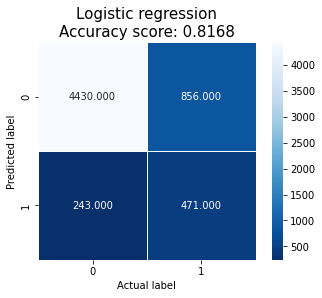

In [15]:
### Let's compute and plot the confusion matrix (on the validation set)

# We compute the model predictions using the validation set
y_pred = logisticRegr.predict(x_val)

# We compute the confusion matrix
cm = metrics.confusion_matrix(y_val, y_pred).T

# We plot the confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues_r")
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
all_sample_title = "Logistic regression" + "\nAccuracy score: {:.4f}".format(accuracy_val)
plt.title(all_sample_title, size = 15)
plt.show()

In [16]:
### Let's check the F1 score and AUC

"""
# We can manually compute the relevant scores from the confusion matrix
precision = cm[1,1] / (cm[1,1] + cm[1,0])
recall = cm[1,1] / (cm[1,1] + cm[0,1] )
f1 = 2*precision*recall/(precision+recall)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1)
"""

print("Precision: ", metrics.precision_score(y_val, y_pred))
print("Recall: ", metrics.recall_score(y_val, y_pred))
print("F1 score: ", metrics.f1_score(y_val, y_pred))
print("ROC AUC: ", metrics.roc_auc_score(y_val, y_pred))

Precision:  0.6596638655462185
Recall:  0.3549359457422758
F1 score:  0.4615384615384616
ROC AUC:  0.6514675448805537


### 3.2. Extreme Gradient Boosting (XGBoost)

Without a baseline performance level to assess whether the training set is performing well, we can only assess whether the model is overfitting by comparing the training and validation errors. With the `XGBClassifier()` default implementation, the validation error is somewhat higher than the training error (there's a 7% difference between them), which indicates the model is somewhat overfitting the data.

In the next two sections we explore some basic strategies to reduce overfitting.

In [17]:
### Let's train our XGBoost classifier

xgbClass = XGBClassifier(verbosity = 1, random_state = 1)
xgbClass.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [18]:
### Let's check the accuracy and error of the training set

y_pred = xgbClass.predict(x_train)
accuracy_training = xgbClass.score(x_train, y_train)
mse_training = metrics.mean_squared_error(y_train, y_pred)
print("Accuracy on training set: ", accuracy_training)
print("MSE on training set: ", mse_training)

Accuracy on training set:  0.8895
MSE on training set:  0.1105


In [19]:
### Let's check the accuracy and error of the validation set

y_pred = xgbClass.predict(x_val)
accuracy_val = xgbClass.score(x_val, y_val)
mse_val = metrics.mean_squared_error(y_val, y_pred)
print("Accuracy on cross validation set: ", accuracy_val)
print("MSE on cross validation set: ", mse_val)

Accuracy on cross validation set:  0.8126666666666666
MSE on cross validation set:  0.18733333333333332


In [20]:
### Let's check the accuracy and error of the test set

y_pred = xgbClass.predict(x_test)
accuracy_test = xgbClass.score(x_test, y_test)
mse_test = metrics.mean_squared_error(y_test, y_pred)
print("Accuracy on test set: ", accuracy_test)
print("MSE on test set: ", mse_test)

Accuracy on test set:  0.8175
MSE on test set:  0.1825


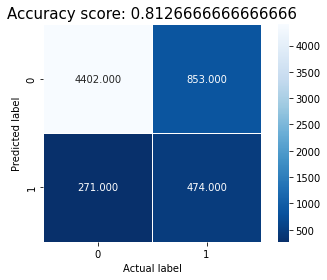

In [21]:
### Let's compute and plot the confusion matrix (on the validation set)

# We compute the model predictions using the validation set
y_pred = xgbClass.predict(x_val)

# We compute the confusion matrix
cm = metrics.confusion_matrix(y_val, y_pred).T

# We plot the confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues_r")
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
all_sample_title = "Accuracy score: {0}".format(accuracy_val)
plt.title(all_sample_title, size = 15)
plt.show()

In [22]:
### Let's check the F1 score and AUC

print("Precision: ", metrics.precision_score(y_val, y_pred))
print("Recall: ", metrics.recall_score(y_val, y_pred))
print("F1 score: ", metrics.f1_score(y_val, y_pred))
print("ROC AUC: ", metrics.roc_auc_score(y_val, y_pred))

Precision:  0.636241610738255
Recall:  0.3571966842501884
F1 score:  0.4575289575289575
ROC AUC:  0.6496019800450599


#### 3.2.1. Overfitting

We can tune several parameters to reduce overfitting. Please visit [Parameters for Tree Booster](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster) and [This question from Stack Exchange](https://stats.stackexchange.com/questions/443259/how-to-avoid-overfitting-in-xgboost-model) for more info on what parameters can be tuned to reduce overfitting. We play with some common choices:

##### subsample

`xgbClass = XGBClassifier(subsample = 0.5, verbosity = 1, random_state = 1)`: overfitting doesn't improve.

##### max_depth

`xgbClass = XGBClassifier(max_depth = 4, verbosity = 1, random_state = 1)`: from 4 downwards overfitting improves.

##### learning_rate

`xgbClass = XGBClassifier(learning_rate = 0.1, verbosity = 1, random_state = 1)`: from 0.1 downwards overfitting improves.

##### min_split_loss

`xgbClass = XGBClassifier(min_split_loss = 3, verbosity = 1, random_state = 1)`: from 3 upwards overfitting improves.

##### early_stopping_rounds

    x_train_fit, x_train_eval, y_train_fit, y_train_eval = train_test_split(x_train, y_train, test_size = 0.2, \
        stratify = y_train, random_state = 1)   
    xgbClass = XGBClassifier(verbosity = 1, random_state = 1)
    xgbClass.fit(x_train_fit, y_train_fit, eval_set = [(x_train_eval, y_train_eval)], early_stopping_rounds = 10)
    y_pred = xgbClass.predict(x_train_fit)
    accuracy_training = xgbClass.score(x_train_fit, y_train_fit)
    mse_training = metrics.mean_squared_error(y_train_fit, y_pred)
    print("Accuracy on training set: ", accuracy_training)
    print("MSE on training set: ", mse_training)

This early stopping implementation somewhat improves overfitting.

#### 3.2.2. Cross-validation

We can also use cross-validation to reduce overfitting. The work below relies heavily on the process I followed while learning about how to make predictions after cross-validating a model. Most of this process is captured in a [Question I posted myself in Stack Overflow](https://stackoverflow.com/questions/75454460/does-it-make-sense-to-use-scikit-learn-cross-val-predict-to-imake-prediction).

Note we use a XGBoost classifier with its default implementation for illustrative purposes. A more rigorous approach would require to systematically explore how the model performs with several parameter values using cross-validation. We briefly discuss this in Section **3.3. Summary**.

In [23]:
# We split the data on training and test sets. The training set is the one used in the cross-validation
x_train_cv, x_test_cv, y_train_cv, y_test_cv = train_test_split(creditCard_ml, creditCard["DEFAULT"], test_size = 0.20, \
    stratify = creditCard["DEFAULT"], random_state = 1)

# We create the model
xgbClassCV = XGBClassifier()

# We define the folding method, using 5 folds for illustrative purposes
kfold = StratifiedKFold(n_splits = 5)

# We run the cross-validation
results_kfold = cross_val_score(xgbClassCV, x_train_cv, y_train_cv, cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results_kfold.mean()*100, results_kfold.std()*100))

Accuracy: 81.26% (0.46%)


In [24]:
### Let's check the accuracy and error of the internal test sets from the cross-validation process

y_pred = cross_val_predict(xgbClassCV, x_train_cv, y_train_cv, cv = kfold)
accuracy_test = metrics.accuracy_score(y_train_cv, y_pred)
mse_test = metrics.mean_squared_error(y_train_cv, y_pred)
print("Accuracy on internal test sets: ", accuracy_test)
print("MSE on internal test sets: ", mse_test)

Accuracy on internal test sets:  0.812625
MSE on internal test sets:  0.187375


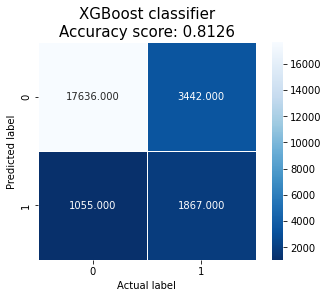

In [25]:
### Let's compute and plot the confusion matrix (on the internal test sets from the cross-validation process)

# We compute the confusion matrix
cm = metrics.confusion_matrix(y_train_cv, y_pred).T

# We plot the confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues_r")
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
all_sample_title = "XGBoost classifier" + "\nAccuracy score: {:.4f}".format(accuracy_test)
plt.title(all_sample_title, size = 15)
plt.show()

In [26]:
### Let's check the F1 score and AUC

print("Precision: ", metrics.precision_score(y_train_cv, y_pred))
print("Recall: ", metrics.recall_score(y_train_cv, y_pred))
print("F1 score: ", metrics.f1_score(y_train_cv, y_pred))
print("ROC AUC: ", metrics.roc_auc_score(y_train_cv, y_pred))

Precision:  0.6389459274469541
Recall:  0.3516669805989829
F1 score:  0.4536508322196574
ROC AUC:  0.6476113513021131


The following function, borrowed and adapted from [How to plot a confusion matrix from a k-fold cross-validation](https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874), helps check whether `cross_val_predict()` works fine:

    import copy as cp
    from typing import Tuple
    
    def cross_val_predict_y(model, kfold : kfold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

        model_ = cp.deepcopy(model)
        
        no_classes = len(np.unique(y))
        
        actual_classes = np.empty([0], dtype=int)
        predicted_classes = np.empty([0], dtype=int)
        predicted_proba = np.empty([0, no_classes]) 

        for train_ndx, test_ndx in kfold.split(X, y):

            train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

            actual_classes = np.append(actual_classes, test_y)

            model_.fit(train_X, train_y)
            predicted_classes = np.append(predicted_classes, model_.predict(test_X))

            try:
                predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
            except:
                predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

        return actual_classes, predicted_classes, predicted_proba

    actual_classes, predicted_classes, _ = cross_val_predict_y(xgbClassCV, kfold, \
        x_train_cv.to_numpy(), y_train_cv.to_numpy())

We can then compute the accuracy, confusion matrix and F1 score using `actual_classes` and `predicted_classes`:

    score = metrics.accuracy_score(actual_classes, predicted_classes)
    cm = metrics.confusion_matrix(actual_classes, predicted_classes).T
    f1_score = metrics.f1_score(actual_classes, predicted_classes)

The accuracy, confusion matrix and F1 score should be the same as the ones obtained after running `cross_val_predict()`.

In [27]:
### Let's make predictions on the test set and compute the generalization error

# We perform a grid search on the cross-validation models
xgbClassGrid = GridSearchCV(estimator = xgbClassCV, param_grid = {}, cv = kfold)
xgbClassGrid.fit(x_train_cv, y_train_cv)

# We select the best model from the cross-validation to make predictions
y_pred = xgbClassGrid.best_estimator_.predict(x_test_cv)

# We check the accuracy and error of the test set
accuracy_test = metrics.accuracy_score(y_test_cv, y_pred)
mse_test = metrics.mean_squared_error(y_test_cv, y_pred)
print("Accuracy on test set: ", accuracy_test)
print("MSE on test set: ", mse_test)

Accuracy on test set:  0.8153333333333334
MSE on test set:  0.18466666666666667


### 3.3. Summary

Comparing the results from the logistic regression to the results from the cross-validated XGBoost classifier, we can conclude both models perform virtually the same.

| Model                     | Accuracy  | Precision | Recall    | F1 score  | ROC AUC   | Generalization error  |
| ---                       | ---       | ---       | ---       | ---       | ---       | ---                   |
| Logistic regression       | 0.8168    | 0.6597    | 0.3549    | 0.4615    | 0.6515    | 0.1762                |
| Cross-validated XGBoost   | 0.8126    | 0.6389    | 0.3517    | 0.4537    | 0.6476    | 0.1847                |

Overall, although the accuracies seem relatively high, the confusion matrices and their metrics tell us both models are rather poor. In particular, the recall score indicates both of them have a high rate of false negatives, i.e., the rate at which the models predict people as non-defaulters when in fact they did default is high. More details on how to interpret a confusion matrix and its metrics can be found in [What does your classification metric tell about your data?](https://towardsdatascience.com/what-does-your-classification-metric-tell-about-your-data-4a8f35408a8b). Moreover, the ROC AUCs indicate the models have a 65% chance of distinguishing between positive and negative classes, which doesn't sound really promising. More details on how to interpret the ROC AUC can be found in [Understanding AUC - ROC curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

Note we only did some basic work to address overfitting. A more rigorous approach would require to perform a hyperpameter tuning using cross-validation. For example, this process would help us determine what are the best `max_depth` and `learning_rate` (among other hyperparameters) for our XGBoost classifier (e.g., see [A guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)). The process can also be run for the logistic regression, although the impact can be rather small (e.g., see [Do I need to tune logistic regression hyperparameters?](https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69)). The blog entry [Cross-validation and hyperparameter tuning: how to optimise your machine learning model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) is a great resource to understand how this process works. Moreover, it packs most of the estimation and evaluation work I do here in a single method.

## 4. Model comparison with cross-validation

We'll take the analysis one step further and apply cross-validation to both models (with their default implementation) and compare them.

In [28]:
### We split the data on training and test sets. The training set is the one used in the cross-validation
x_train_cv, x_test_cv, y_train_cv, y_test_cv = train_test_split(creditCard_ml, creditCard["DEFAULT"], test_size = 0.20, \
    stratify = creditCard["DEFAULT"], random_state = 1)

### We create both models. For illustrative purposes, we'll work with their default implementation
logisticRegrCV = LogisticRegression(verbose = 1, random_state = 1)
xgbClassCV = XGBClassifier(verbosity = 1, random_state = 1)

### We define the folding method, using 5 folds for illustrative purposes
kfold = StratifiedKFold(n_splits = 5)

In [29]:
### We create lists to store performance metrics of all 5 folds
accs = [] # Accuray scores
precs = [] # Precision scores
recalls = [] # Recall scores
f1s = [] # F1 scores
aucs = [] # ROC AUC scores

### Accuracy
# This retrieves the accuracy scores of the 5 folds
accuracy = np.round(cross_val_score(logisticRegrCV, x_train_cv, y_train_cv, scoring = "accuracy", cv = kfold), 4)
# We store them in a list (this is done to put the scores later in a DataFrame)
accs.append(accuracy)
# We compute the average score across the 5 folds
accuracy_avg = round(accuracy.mean(), 4)

### Precision
precision = np.round(cross_val_score(logisticRegrCV, x_train_cv, y_train_cv, scoring = "precision", cv = kfold), 4)
precs.append(precision)
precision_avg = round(precision.mean(), 4)

### Recall
recall = np.round(cross_val_score(logisticRegrCV, x_train_cv, y_train_cv, scoring = "recall", cv = kfold), 4)
recalls.append(recall)
recall_avg = round(recall.mean(), 4)

### F1
f1 = np.round(cross_val_score(logisticRegrCV, x_train_cv, y_train_cv, scoring = "f1", cv = kfold), 4)
f1s.append(f1)
f1_avg = round(f1.mean(), 4)

### ROC AUC
auc = np.round(cross_val_score(logisticRegrCV, x_train_cv, y_train_cv, scoring = "roc_auc", cv = kfold), 4)
aucs.append(auc)
auc_avg = round(auc.mean(), 4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/jacasta2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/jacasta2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

In [30]:
### Let's check the logistic regression results

print("Logistic regression")
print("- Accuracy: ", accuracy, " Avg: ", accuracy_avg)
print("- Precision: ", precision, " Avg: ", precision_avg)
print("- Recall: ", recall, " Avg: ", recall_avg)
print("- F1: ", f1, " Avg: ", f1_avg)
print("- ROC AUC: ", auc, " Avg: ", auc_avg)

Logistic regression
- Accuracy:  [0.8138 0.824  0.8179 0.8281 0.8202]  Avg:  0.8208
- Precision:  [0.6473 0.69   0.6734 0.7054 0.6846]  Avg:  0.6801
- Recall:  [0.3459 0.371  0.3437 0.3832 0.3475]  Avg:  0.3583
- F1:  [0.4509 0.4825 0.4551 0.4966 0.461 ]  Avg:  0.4692
- ROC AUC:  [0.7637 0.7752 0.7592 0.7906 0.7724]  Avg:  0.7722


In [31]:
### We repeat the process for the XGBoost classifier

accs = []
precs = []
recalls = []
f1s = []
aucs = []

accuracy = np.round(cross_val_score(xgbClassCV, x_train_cv, y_train_cv, scoring = "accuracy", cv = kfold), 4)
accs.append(accuracy)
accuracy_avg = round(accuracy.mean(), 4)
precision = np.round(cross_val_score(xgbClassCV, x_train_cv, y_train_cv, scoring = "precision", cv = kfold), 4)
precs.append(precision)
precision_avg = round(precision.mean(), 4)
recall = np.round(cross_val_score(xgbClassCV, x_train_cv, y_train_cv, scoring = "recall", cv = kfold), 4)
recalls.append(recall)
recall_avg = round(recall.mean(), 4)
f1 = np.round(cross_val_score(xgbClassCV, x_train_cv, y_train_cv, scoring = "f1", cv = kfold), 4)
f1s.append(f1)
f1_avg = round(f1.mean(), 4)
auc = np.round(cross_val_score(xgbClassCV, x_train_cv, y_train_cv, scoring = "roc_auc", cv = kfold), 4)
aucs.append(auc)
auc_avg = round(auc.mean(), 4)

In [32]:
### Let's check the XGBoosst classifier results

print("XGBoost classifier")
print("- Accuracy: ", accuracy, " Avg: ", accuracy_avg)
print("- Precision: ", precision, " Avg: ", precision_avg)
print("- Recall: ", recall, " Avg: ", recall_avg)
print("- F1: ", f1, " Avg: ", f1_avg)
print("- ROC AUC: ", auc, " Avg: ", auc_avg)

XGBoost classifier
- Accuracy:  [0.81   0.8112 0.8073 0.8208 0.8138]  Avg:  0.8126
- Precision:  [0.6305 0.6304 0.6187 0.6706 0.6438]  Avg:  0.6388
- Recall:  [0.3393 0.355  0.3362 0.3738 0.354 ]  Avg:  0.3517
- F1:  [0.4412 0.4542 0.4356 0.48   0.4569]  Avg:  0.4536
- ROC AUC:  [0.7529 0.7646 0.7433 0.7794 0.7626]  Avg:  0.7606


The following function, borrowed and adapted from [Cross-validation and hyperparameter tuning: how to optimise your machine learning model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d), encapsulates the process above in a function.

In [33]:
def cv_comparison(models, names, X, y, cv):
    """
    This function performs a k-fold cross-validation for several models.

    Args:
        models: list of models to be cross-validated.
        names: list with model names.
        X: training set used in the cross-validation.
        y: target classes used in the cross-validation.
        cv: the number of folds or method. 

    Returns:
        cv_scores: DataFrame with the average scores of the cross-validation for each model.
        accs: list with the accuracy of each fold for each model.
        precs: list with the precision of each fold for each model.
        recalls: list with the recall of each fold for each model.
        f1s: list with the F1 score of each fold for each model.
        aucs: list with the ROC AUC of each fold for each model.
    """
    
    cv_scores = pd.DataFrame()
    accs = []
    precs = []
    recalls = []
    f1s = []
    aucs = []
    
    # Loop through the models, run the CV, add the average scores to the DataFrame and all the scores to their
    # respective lists
    for (model, name) in zip(models, names):
        
        accuracy = np.round(cross_val_score(model, X, y, scoring = "accuracy", cv = cv), 4)
        accs.append(accuracy)
        accuracy_avg = round(accuracy.mean(), 4)
        precision = np.round(cross_val_score(model, X, y, scoring = "precision", cv = cv), 4)
        precs.append(precision)
        precision_avg = round(precision.mean(), 4)
        recall = np.round(cross_val_score(model, X, y, scoring = "recall", cv = cv), 4)
        recalls.append(recall)
        recall_avg = round(recall.mean(), 4)
        f1 = np.round(cross_val_score(model, X, y, scoring = "f1", cv = cv), 4)
        f1s.append(f1)
        f1_avg = round(f1.mean(), 4)
        auc = np.round(cross_val_score(model, X, y, scoring = "roc_auc", cv = cv), 4)
        aucs.append(auc)
        auc_avg = round(auc.mean(), 4)
        
        # The model names are used as the feature names
        cv_scores[str(name)] = [accuracy_avg, precision_avg, recall_avg, f1_avg, auc_avg]
    
    # The index of the DataFrame corresponds to the names of the performance metrics
    cv_scores.index = ["Accuracy", "Precision", "Recall", "F1 score", "ROC AUC"]
    
    return cv_scores, accs, precs, recalls, f1s, aucs

In [34]:
### We create both models. For illustrative purposes, we'll work with their default implementation
logisticRegrCV = LogisticRegression(random_state = 1)
xgbClassCV = XGBClassifier(random_state = 1)

### We define the folding method, using 5 folds for illustrative purposes
kfold = StratifiedKFold(n_splits = 5)

### Put the models in a list
models = [logisticRegrCV, xgbClassCV]
names = ["Logistic Regression", "XGBoost classifier"]

### Run the cross-validation comparison
scores, accs, precs, recalls, f1s, aucs = cv_comparison(models, names, x_train_cv, y_train_cv, kfold)

/home/jacasta2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/jacasta2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

In [35]:
### Let's check the results

scores

,Logistic Regression,XGBoost classifier
Accuracy,0.8208,0.8126
Precision,0.6801,0.6388
Recall,0.3583,0.3517
F1 score,0.4692,0.4536
ROC AUC,0.7722,0.7606


In [36]:
### We can also check a given metric across each fold

def foldMetrics(metricList, comparisonDf):
    """
    This function returns a DataFrame with the value of a performance metric in each fold from a previously performed
        cross-validation.

    Args:
        metricList: list with the values of the performance metric in all folds.
        comparisonDf: DataFrame used to create the index of the returned DataFrame. The index corresponds to the
            model names.
        
    Returns:
        metricDf: DataFrame with the values of a performance metric for each fold of a cross-validation.
    """

    metricDf = pd.DataFrame(metricList, index = comparisonDf.columns, columns = ["1st Fold", "2nd Fold", \
        "3rd fold", "4th fold", "5th fold"])
    metricDf["Average"] = np.round(metricDf.mean(axis = 1), 4)

    return metricDf                                                                        

In [37]:
### Let's check the accuracies

foldMetrics(accs, scores)

,1st Fold,2nd Fold,3rd fold,4th fold,5th fold,Average
Logistic Regression,0.8138,0.8240,0.8179,0.8281,0.8202,0.8208
XGBoost classifier,0.8100,0.8112,0.8073,0.8208,0.8138,0.8126


In [38]:
### Let's check the precisions

foldMetrics(precs, scores)

,1st Fold,2nd Fold,3rd fold,4th fold,5th fold,Average
Logistic Regression,0.6473,0.6900,0.6734,0.7054,0.6846,0.6801
XGBoost classifier,0.6305,0.6304,0.6187,0.6706,0.6438,0.6388


In [39]:
### Let's check the recalls

foldMetrics(recalls, scores)

,1st Fold,2nd Fold,3rd fold,4th fold,5th fold,Average
Logistic Regression,0.3459,0.371,0.3437,0.3832,0.3475,0.3583
XGBoost classifier,0.3393,0.355,0.3362,0.3738,0.3540,0.3517


In [40]:
### Let's check the F1 scores

foldMetrics(f1s, scores)

,1st Fold,2nd Fold,3rd fold,4th fold,5th fold,Average
Logistic Regression,0.4509,0.4825,0.4551,0.4966,0.4610,0.4692
XGBoost classifier,0.4412,0.4542,0.4356,0.4800,0.4569,0.4536


In [41]:
### Let's check the ROC AUCs

foldMetrics(aucs, scores)

,1st Fold,2nd Fold,3rd fold,4th fold,5th fold,Average
Logistic Regression,0.7637,0.7752,0.7592,0.7906,0.7724,0.7722
XGBoost classifier,0.7529,0.7646,0.7433,0.7794,0.7626,0.7606


### Summary

Overall, both models perform in a similar way and rather poorly. The confusion matrix metrics tell us both models are rather poor. In particular, the Recall score indicates both of them have a high rate of false negatives. Perhaps the only important difference is in precision, where the logistic regression clearly outperforms the XGBoost classifier. Checking the DataFrames of each performance metric allows to see in more detail how the metrics behaved during the cross-validation. This shows the poor performance is consistent across folds for both models and how the logistic regression consistently outperforms the XGBoost classifier in precision across folds.

## 5. Hyperparameter tuning

The final exercise in this model selection process we've been running is to fine-tune the hyperparameters of the models to find a good set of them for each model and make a final model comparison. To achieve this, we'll perform a hyperparameter tuning using cross-validation for each model. This is a more systematic approach than the manual iterations we ran in **Section 3.2.1** for the XGBoost classifier.

In [42]:
### We split the data on training and test sets. The training set is the one used in the cross-validation
x_train_ht, x_test_ht, y_train_ht, y_test_ht = train_test_split(creditCard_ml, creditCard["DEFAULT"], test_size = 0.20, \
    stratify = creditCard["DEFAULT"], random_state = 1)

### We define the folding method, using 5 folds for illustrative purposes
kfold = StratifiedKFold(n_splits = 5)

### 5.1. Logistic regression

While the gains from a hyperparameter tuning of a logistic regression are overall rather small (e.g., see [Do I need to tune logistic regression hyperparameters?](https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69)), we'll still perform this process for the sake of completeness. In [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) we can check the parameters we can fine-tune. Note we would need to check what combinations of the `solver` and `penalty` parameters can be used in the process. Since we'll try not so many parameter combinations, we can use a grid search, which will search the best parameters testing all possible parameter combinations (see [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for details about the cross-validation using grid search).

[This question from Stack Overflow](https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression) and [Tuning parameters for logistic regression](https://www.kaggle.com/code/joparga3/2-tuning-parameters-for-logistic-regression) are additional sources I reviewed to perform the hyperparameter tuning of the logistic regression. The latter has code to plot validation curves, which are pretty useful to visualize the tradeoff between training and validation performance as we change the hyperparameters.

In [43]:
### We specify the hyperparameters and their different levels

# The solver used in the optimization problem
lgSolver = ["lbfgs", "newton-cg", "sag"] # 3 levels

# The penalty used by the solver
lgPenalty = ["none", "l2"] # 2 levels

# The inverse of the regularization strength. Smaller values specify a stronger regularization
lgC = [0.001, 0.01, 0.1, 1, 10] # 5 levels

# We create the grid for the search. Note we'll test 3*2*5 = 30 parameter combinations
lgGrid = {"solver": lgSolver,
          "penalty": lgPenalty,
          "C": lgC,
}

In [44]:
### We create the logistic regression
logisticRegrHT = LogisticRegression()

### We create the grid search
logisticRegrGrid = GridSearchCV(estimator = logisticRegrHT, param_grid = lgGrid, cv = kfold, n_jobs = -1, \
    verbose = 3)

### We run the grid search
logisticRegrGrid.fit(x_train_ht, y_train_ht)
    # The cell ran in 3m 29.4s

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['none', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'sag']},
             verbose=3)

In [45]:
### Let's check some of the results from the grid search process

# Best hyperparameters
print("Best hyperparameters")
print(logisticRegrGrid.best_params_)

# Best score (the grid search computes accuracy by default, but we can specify a different metric)
print("\nBest accuracy score")
print(logisticRegrGrid.best_score_)

# Mean score from the test set for each parameter combination (across the 5 folds)
print("\nMean accuracy score from the test set for each parameter combination")
print(logisticRegrGrid.cv_results_.get("mean_test_score"))

# Overall mean score from the test sets across all parameter combinations
print("\nOverall mean accuracy score from the test sets across all parameter combinations")
print(np.mean(logisticRegrGrid.cv_results_.get("mean_test_score")))

Best hyperparameters
{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

Best accuracy score
0.8211666666666668

Mean accuracy score from the test set for each parameter combination
[0.82116667 0.821      0.82108333 0.79708333 0.79708333 0.79708333
 0.82116667 0.821      0.82108333 0.814375   0.814375   0.814375
 0.82116667 0.821      0.82108333 0.82083333 0.82079167 0.82079167
 0.82116667 0.821      0.82108333 0.82079167 0.82079167 0.82079167
 0.82116667 0.821      0.82108333 0.82108333 0.82116667 0.82116667]

Overall mean accuracy score from the test sets across all parameter combinations
0.8179611111111112


### 5.2. XGBoost classifier

In this case, we'll fine-tune more hyperparameters, some of them with up to 10 levels or values. In [XGBoost parameters](https://xgboost.readthedocs.io/en/stable/parameter.html) we can check the parameters we can fine-tune.

Since we'll try a large number of parameter combinations, a grid search won't be efficient since it'll consume a high computation power. Instead, we'll use a randomized grid search. Details about the cross-validation using a randomized grid search can be found in [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Moreover, [Hyper parameter tuning with randomised grid search](https://towardsdatascience.com/hyper-parameter-tuning-with-randomised-grid-search-54f865d27926) provides details about the efficiency of this approach and [Cross-validation and hyperparameter tuning: How to optimise your machine learning model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) provides two examples of its application: with a random forest regressor and a XGBoost regressor.

I reviewed some additional sources to perform the hyperparameter tuning of the XGBoost classifier (the last two also provide code to plot validation curves):

- [A guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)
- [Tuning XGBoost models](https://dwbi1.wordpress.com/2021/11/22/tuning-xgboost-models/)
- [Complete guide to parameter tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- [Hyperparameter tuning in XGBoost](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f)
- [How to tune the number and size of decision trees with XGBoost in Python](https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/)
- [Hyperparameter tuning for hyperaccurate XGBoost model](https://medium.com/broadhorizon-cmotions/hyperparameter-tuning-for-hyperaccurate-xgboost-model-d6e6b8650a11)

In [46]:
### We specify the hyperparameters and their different levels

# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(50, 500, 10)] # 10 levels

# Maximum number of levels in a tree
xgb_max_depth = [int(x) for x in np.arange(2, 9)] # 7 levels

# Learning rate
xgb_eta = [0.01, 0.03, 0.1, 0.3] # 4 levels

# Minimum number of observations (rows) needed in each node
xgb_min_child_weight = [int(x) for x in np.arange(1, 11)] # 10 levels

# Fraction of rows to sample when constructing each tree
xgb_subsample = [x for x in np.linspace(0.5, 1, 6)] # 6 levels

# Fraction of features (columns) to sample when constructing each tree
xgb_colsample_bytree = [x for x in np.linspace(0.5, 1, 6)] # 6 levels

# Minimum loss reduction required to make further partitions
xgb_gamma = [x for x in np.arange(0, 11, 2)] # 6 levels

# We create the grid for the search. Note we would test 10*7*4*10*6*6*6 = 604,800 parameter combinations!
xgb_grid = {"n_estimators": xgb_n_estimators,
            "max_depth": xgb_max_depth,
            "eta": xgb_eta,
            "min_child_weight": xgb_min_child_weight,
            "subsample": xgb_subsample,
            "colsample_bytree": xgb_colsample_bytree,
            "gamma": xgb_gamma,
}

In [47]:
### We create the XGBoost classifier
xgbClassHT = XGBClassifier()

### We create the randomized grid search
xgbClassRand = RandomizedSearchCV(estimator = xgbClassHT, param_distributions = xgb_grid, n_iter = 60, \
    cv = kfold, n_jobs = -1, verbose = 2, random_state = 1)

### We run the randomized grid search
xgbClassRand.fit(x_train_ht, y_train_ht)
    # The cell ran in 20m 12.7s

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           int...
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'colsample_bytree'

In [48]:
### Let's check some of the results from the randomized grid search process

# Best hyperparameters
print("Best hyperparameters")
print(xgbClassRand.best_params_)

# Best score (the search computes accuracy by default, but we can specify a different metric)
print("\nBest accuracy score")
print(xgbClassRand.best_score_)

# Mean score from the test set for each parameter combination (across the 5 folds)
print("\nMean accuracy score from the test set for each parameter combination")
print(xgbClassRand.cv_results_.get("mean_test_score"))

# Overall mean score from the test sets across all parameter combinations
print("\nOverall mean accuracy score from the test sets across all parameter combinations")
print(np.mean(xgbClassRand.cv_results_.get("mean_test_score")))

Best hyperparameters
{'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 6, 'max_depth': 6, 'gamma': 0, 'eta': 0.03, 'colsample_bytree': 0.7}

Best accuracy score
0.8212916666666669

Mean accuracy score from the test set for each parameter combination
[0.82033333 0.81979167 0.820625   0.79791667 0.81991667 0.82020833
 0.82070833 0.81416667 0.82129167 0.81908333 0.82016667 0.81070833
 0.81954167 0.81891667 0.81945833 0.81908333 0.82004167 0.81091667
 0.818625   0.81558333 0.79833333 0.82091667 0.817875   0.81870833
 0.81975    0.81416667 0.821      0.81275    0.81925    0.82045833
 0.81945833 0.820625   0.818375   0.819      0.82045833 0.81391667
 0.81954167 0.82041667 0.817125   0.8185     0.820625   0.81916667
 0.820875   0.8195     0.81895833 0.82095833 0.82104167 0.81141667
 0.81958333 0.79579167 0.819375   0.81741667 0.81854167 0.81975
 0.81979167 0.82008333 0.82045833 0.82033333 0.79883333 0.816625  ]

Overall mean accuracy score from the test sets across all parameter com

### 5.3. Final validation

Finally, we'll train and validate each fine-tuned model and compare their performance.

In [49]:
### Let's train the models

# We create the logistic regression
logisticRegrFT = LogisticRegression(solver = "newton-cg",
    penalty = "l2",
    C = 10)

# We create the XGBoost classifier
xgbClassFT = XGBClassifier(n_estimators = 200,
    max_depth = 6,
    eta = 0.03,
    min_child_weight = 6,
    subsample = 0.7,
    colsample_bytree = 0.7,
    gamma = 0)

# We train the models
logisticRegrFT.fit(x_train_ht, y_train_ht)
xgbClassFT.fit(x_train_ht, y_train_ht)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False, eta=0.03,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0299999993, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

The following function, borrowed and adapted from [Cross-validation and hyperparameter tuning: how to optimise your machine learning model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d), encapsulates the validation process in a function.

In [50]:
def model_comparison(models, names, X, y):
    """
    This function validates several models.

    Args:
        models: list of models to be validated.
        names: list with model names.
        X: validation set.
        y: target classes used in the validation.
        
    Returns:
        cv_scores: DataFrame with the scores of the prediction for each model.
    """
    
    cv_scores = pd.DataFrame()
    
    # Loop through the models, make predictions and add the scores to the DataFrame
    for (model, name) in zip(models, names):
        
        predictions = model.predict(X)
        accuracy = metrics.accuracy_score(y, predictions)
        precision = metrics.precision_score(y, predictions)
        recall = metrics.recall_score(y, predictions)
        f1 = metrics.f1_score(y, predictions)
        auc = metrics.roc_auc_score(y, predictions)
        cm = metrics.confusion_matrix(y, predictions).T

        # The model names are used as the feature names
        cv_scores[str(name)] = [accuracy, precision, recall, f1, auc, cm]
    
    # The index of the DataFrame corresponds to the names of the performance metrics
    cv_scores.index = ["Accuracy", "Precision", "Recall", "F1 score", "ROC AUC", "CM"]
    
    return cv_scores

In [51]:
models = [logisticRegrFT, xgbClassFT]
names = ["Logistic regression", "XGBoost classifier"]
final_scores = model_comparison(models, names, x_test_ht, y_test_ht)

In [52]:
### Let's check the results

final_scores

,Logistic regression,XGBoost classifier
Accuracy,0.82,0.817333
Precision,0.678726,0.66571
Recall,0.353429,0.349661
F1 score,0.464817,0.458498
ROC AUC,0.652961,0.6499
CM,"[[4451, 858], [222, 469]]","[[4440, 863], [233, 464]]"


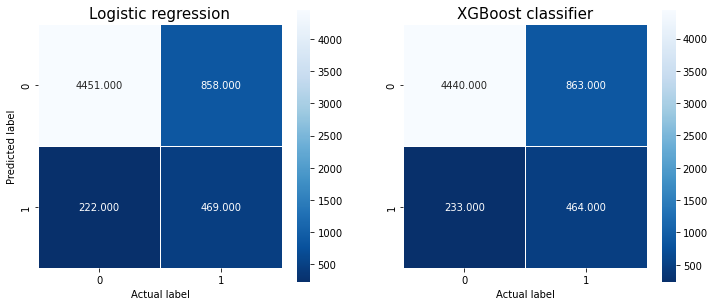

In [53]:
### Lets's plot the confusion matrices

# We extract the confusion matrices from the DataFrame
cm1 = final_scores.iloc[5, 0]
cm2 = final_scores.iloc[5, 1]

# We plot them
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.heatmap(cm1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues_r", ax = ax[0])
ax[0].set_title("Logistic regression", size = 15)
sns.heatmap(cm2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues_r", ax = ax[1])
ax[1].set_title("XGBoost classifier", size = 15)

# Set common labels
    # https://stackoverflow.com/questions/6963035/how-to-set-common-axes-labels-for-subplots
plt.setp(ax[:], xlabel = "Actual label")
plt.setp(ax[0], ylabel = "Predicted label")

plt.show()

### 5.4. Summary

Overall, both models perform in a similar way and rather poorly. The confusion matrix metrics tell us both models are rather poor. In particular, the recall scores indicate both of them have a high rate of false negatives. Differences across the performance metrics between the models are pretty consistent, with the logistic regression slightly ourperforming the XGBoost classifier.

## 6. Concluding remarks

This modeling exercise delved into a model selection process, going from a train/validation/test approach to a hyperparamteter tuning using cross-validation. While we only applied this analysis for a logistic regression and a XGBoost classifier, it can be extended to other classification models such as a random forest and a neural network.

While overall the logistic regression outperformed the GXBoost classifier, the performance difference is rather small.